In [202]:
#import necessary library
import math
import numpy as np
import pandas as pd
from pylab import plt
from scipy.optimize import minimize
plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.5f}'.format
#Create a FinancialData class:


#Create a FinancialData class:
    initial a class
    1) download data from csv url
    2) prepare the data for calcualte model
    

In [203]:
class FinancialData:
    url = 'https://hilpisch.com/indices_eikon_eod_data.csv'
    def __init__(self):
        self.financialdata =None
        self.returns = None
        self.downloadData()
        self.prepare_data()
        self.no_assets = len(self.financialdata.columns)
    def downloadData(self):
        self.financialdata = pd.read_csv(self.url, index_col =0, parse_dates=True)
    def prepare_data(self):
        self.returns = np.log(self.financialdata /self.financialdata.shift(1)).dropna()
        
    

In [204]:
fd = FinancialData()

In [205]:
fd.no_assets

8

## MVP Class
    init()
    portfolio_return()
    portfolio_variance()
    portfolio_volatility()
    portfolio_sharpe()
    

In [206]:
class MVPmodel(FinancialData):
    def __init__(self):
        super().__init__()
        self.weights = self.no_assets * [1/ self.no_assets]
    def portfolio_return(self,weights,days=252):
        return np.dot(self.returns.mean(),weights)*days
    def portfolio_variance(self, weights,days =252):
        return np.dot(weights, np.dot(self.returns.cov(), weights)) * days
    def portfolio_volatility(self,weights,days=252):
        return math.sqrt(self.portfolio_variance(weights,days))
    def portfolio_sharpe(self,weights, days=252):
        shape = (self.portfolio_return(weights,days) /
                 self.portfolio_volatility(weights,days))
        return shape
    def _set_bounds_constraints(self, bnds, cons):
        if bnds is None:
            self.bnds = self.no_assets*[(0,1)]
        else:
            self.bnds = bnds
        if cons is None:
            self.cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}
        else:
            self.cons = cons
    def max_sharpe_portfolio(self,bnds=None, cons=None):
        self._set_bounds_constraints(bnds,cons)
        sharpe_f = lambda weights: -self.portfolio_sharpe(weights)
        opt = minimize(sharpe_f, self.weights,bounds=self.bnds,
                       constraints = self.cons)
        self.results =self._return_result(opt, 'Maximum Shape')
        return self.results
    def _return_result(self,opt,kind):
        ret = self.portfolio_return(opt['x'])
        vol = self.portfolio_volatility(opt['x'])
        sharpe = self.portfolio_sharpe(opt['x'])
        weights= pd.DataFrame(opt['x'], index =self.financialdata.columns,columns=['weights',])
        res ={'kind': kind, 'weights': weights.round(7), 'return' : ret, 
              'volatiltiy': vol, 'sharpe' : sharpe}
        return res
    #optimization methods to
    #derive the minimum variance portfolio as well as the maximum Sharpe
    #portfolio.
    

In [207]:
mvpmodel = MVPmodel()

In [208]:
mvpmodel.financialdata.columns

Index(['.FCHI', '.FTSE', '.GDAXI', '.HSI', '.NDX', '.NSEI', '.SPX', '.SSEC'], dtype='object')

In [209]:
mvpmodel.portfolio_return(mvpmodel.weights)

0.10398621259009806

In [210]:
mvpmodel.portfolio_volatility(mvpmodel.weights)

0.14705487415271787

In [211]:
mvpmodel.portfolio_sharpe(mvpmodel.weights)

0.7071252359993685

In [212]:
mvpmodel.max_sharpe_portfolio()

{'kind': 'Maximum Shape',
 'weights':         weights
 .FCHI   0.00000
 .FTSE   0.00000
 .GDAXI  0.00000
 .HSI    0.00000
 .NDX    0.47421
 .NSEI   0.52579
 .SPX    0.00000
 .SSEC   0.00000,
 'return': 0.18372643865394744,
 'volatiltiy': 0.1632772763287996,
 'sharpe': 1.1252419368140876}

In [408]:
class RollbackTesting(MVPmodel):
    def __init__(self,lookback_period):
        super().__init__()
        self.lookback_period = lookback_period
    def backtest(self, start_date, end_date, rebalance_period ='1W'):
        dates = pd.date_range(start=start_date, end=end_date, freq= rebalance_period)
        portfolio_returns =[]
        cal_looback = int(self.lookback_period / 5)
        org_returns = self.returns
        for i in range(cal_looback ,len(dates) -1):        
            train_end = dates[i]
            test_start = dates[i + 1]
            #print(train_end)
            test_end = dates[i + 2] if i + 2 < len(dates) else end_date
            train_data = org_returns[:train_end][-self.lookback_period:]
            test_data = org_returns[test_start:test_end]
            #rint(f'{test_start}:{test_end}:{len(test_data)}')  
            self.returns = train_data
            weights = self.max_sharpe_portfolio()['weights'].values.flatten()
            if len(test_data) > 0 :
                test_return = np.sum(weights * test_data.mean())
                portfolio_returns.append(test_return)
            else:
                print(test_start)
        performance_df = pd.DataFrame(portfolio_returns,  columns=['Portfolio Return'])
        performance_df['Cumulative Return'] = (1 + performance_df['Portfolio Return']).cumprod() - 1 
        return performance_df
    
    def annualized_return(self, performance_df):
        """
        Calculate the annualized return of the portfolio.
        :param performance_df: DataFrame of portfolio performance
        :return: Annualized return
        """
        total_return = performance_df['Cumulative Return'].iloc[-1]
        num_years = len(performance_df) / 52  # Assuming weekly returns
        return (1 + total_return) ** (1 / num_years) - 1
    
    
    def plot_backtest(self, backtest_results):
        """
        Plot the results of the backtest.
        
        Parameters:
        backtest_results (pandas.DataFrame): Results of the backtest.
        """
        plt.figure(figsize=(12, 6))
        backtest_results['Cumulative Return'].plot()
        plt.title('Backtest Portfolio Value')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.grid()
        plt.show()

In [409]:
rollbacktest = RollbackTesting(504)

In [410]:
rollbacktest.returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958 entries, 2016-01-05 to 2020-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   .FCHI   958 non-null    float64
 1   .FTSE   958 non-null    float64
 2   .GDAXI  958 non-null    float64
 3   .HSI    958 non-null    float64
 4   .NDX    958 non-null    float64
 5   .NSEI   958 non-null    float64
 6   .SPX    958 non-null    float64
 7   .SSEC   958 non-null    float64
dtypes: float64(8)
memory usage: 67.4 KB


In [411]:
performance_df = rollbacktest.backtest(start_date='2016-01-01', end_date='2020-01-01')

# Calculate the annualized return
annualized_return = rollbacktest.annualized_return(performance_df)

print("Annualized Return:", annualized_return)
print(performance_df)

2018-09-30 00:00:00
2019-02-03 00:00:00
2019-04-28 00:00:00
Annualized Return: 0.047767695184654846
     Portfolio Return  Cumulative Return
0             0.00176            0.00176
1             0.00160            0.00336
2            -0.00024            0.00312
3             0.00556            0.00870
4             0.00307            0.01180
..                ...                ...
100          -0.00160            0.09485
101           0.00239            0.09747
102           0.00330            0.10110
103          -0.00007            0.10102
104          -0.00201            0.09880

[105 rows x 2 columns]


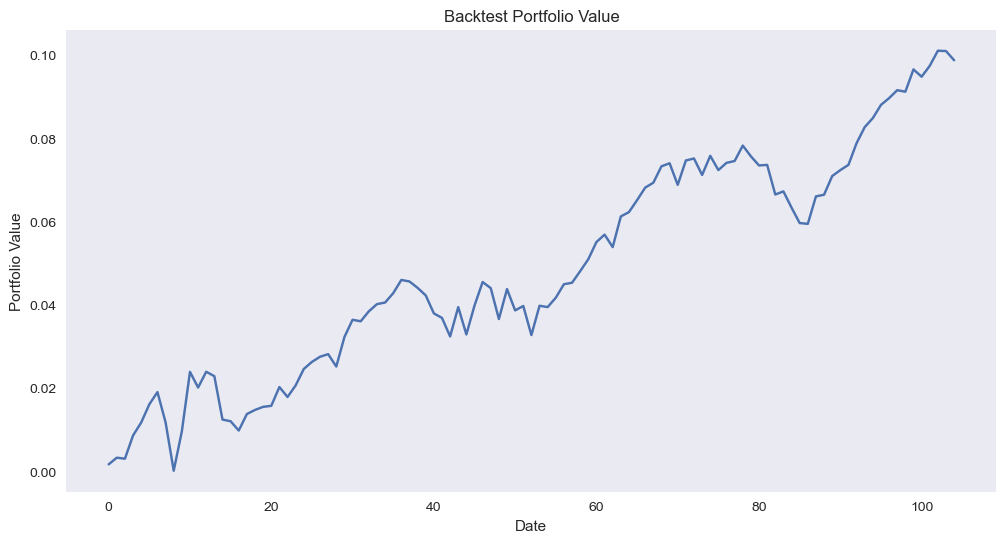

In [412]:
rollbacktest.plot_backtest(performance_df)

In [ ]:
  
        for i in range(len(dates) -2):
            train_end = dates[i]
            test_start = dates[i+1]
            test_end = dates[ i + 2] if i + 2 < len(dates) else end_date
            #print(train_end)
            self.returns = org_returns.loc[:train_end][-self.lookback_period:]
            print(self.max_sharpe_portfolio())
            #test_data = self.returns[test_start:test_end]

In [252]:
rollbacktest.backtest(start_date='2016-01-01', end_date='2023-01-01')

              .FCHI    .FTSE   .GDAXI     .HSI     .NDX    .NSEI     .SPX  \
Date                                                                        
2016-01-05  0.00335  0.00716  0.00259 -0.00651 -0.00305 -0.00085  0.00201   
2016-01-06 -0.01268 -0.01046 -0.00936 -0.00986 -0.00900 -0.00562 -0.01320   
2016-01-07 -0.01731 -0.01984 -0.02319 -0.03135 -0.03161 -0.02256 -0.02399   
2016-01-08 -0.01598 -0.00702 -0.01316  0.00590 -0.00815  0.00436 -0.01090   
2016-01-11 -0.00486 -0.00689 -0.00247 -0.02802  0.00298 -0.00495  0.00085   
...             ...      ...      ...      ...      ...      ...      ...   
2017-04-25  0.00171  0.00151  0.00097  0.01302  0.00726  0.00957  0.00607   
2017-04-26  0.00189  0.00180  0.00046  0.00500 -0.00128  0.00485 -0.00049   
2017-04-27 -0.00306 -0.00710 -0.00233  0.00487  0.00543 -0.00104  0.00055   
2017-04-28 -0.00083 -0.00460 -0.00046 -0.00338  0.00220 -0.00409 -0.00191   
2017-05-02  0.00697  0.00638  0.00560  0.00329  0.01078  0.00105  0.00292   

In [233]:
start_date = '2020-01-01'
end_date = '2023-01-01'
rebalance_period ='1W'
dates = pd.date_range(start=start_date, end=end_date, freq= rebalance_period)

In [151]:
for i in range(len(dates) -2):
            train_end = dates[i]
            test_start = dates[i+1]
            print(train_end)

2020-01-05 00:00:00
2020-01-12 00:00:00
2020-01-19 00:00:00
2020-01-26 00:00:00
2020-02-02 00:00:00
2020-02-09 00:00:00
2020-02-16 00:00:00
2020-02-23 00:00:00
2020-03-01 00:00:00
2020-03-08 00:00:00
2020-03-15 00:00:00
2020-03-22 00:00:00
2020-03-29 00:00:00
2020-04-05 00:00:00
2020-04-12 00:00:00
2020-04-19 00:00:00
2020-04-26 00:00:00
2020-05-03 00:00:00
2020-05-10 00:00:00
2020-05-17 00:00:00
2020-05-24 00:00:00
2020-05-31 00:00:00
2020-06-07 00:00:00
2020-06-14 00:00:00
2020-06-21 00:00:00
2020-06-28 00:00:00
2020-07-05 00:00:00
2020-07-12 00:00:00
2020-07-19 00:00:00
2020-07-26 00:00:00
2020-08-02 00:00:00
2020-08-09 00:00:00
2020-08-16 00:00:00
2020-08-23 00:00:00
2020-08-30 00:00:00
2020-09-06 00:00:00
2020-09-13 00:00:00
2020-09-20 00:00:00
2020-09-27 00:00:00
2020-10-04 00:00:00
2020-10-11 00:00:00
2020-10-18 00:00:00
2020-10-25 00:00:00
2020-11-01 00:00:00
2020-11-08 00:00:00
2020-11-15 00:00:00
2020-11-22 00:00:00
2020-11-29 00:00:00
2020-12-06 00:00:00
2020-12-13 00:00:00


In [152]:
rollbacktest.backtest(start_date='2016-01-01', end_date='2023-01-01')

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

In [288]:
for i in range(5 , 9):      
    print(i)

5
6
7
8
